# Playing Atari with Deep Reinforcement Learning

Paper: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

Walkthorugh: https://becominghuman.ai/lets-build-an-atari-ai-part-0-intro-to-rl-9b2c5336e0ec

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import gym
import time
import json
from copy import deepcopy

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, Add
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.callbacks import History
from keras.backend import tf as ktf
from keras.callbacks import Callback as KerasCallback, CallbackList as KerasCallbackList
from keras.callbacks import EarlyStopping, TensorBoard, CSVLogger
from keras.utils.generic_utils import Progbar
from keras import backend as K

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy, Policy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

from IPython import display
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# check our devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Visualizer Callback
class Visualizer(KerasCallback):
    def __init__(self, view_machine_mode=False, show_labels=True):
        self.machine_mode = view_machine_mode
        self.show_labels = show_labels
    
    def _set_env(self, env):
        self.env = env
        self.img = plt.imshow(self.env.render(mode='rgb_array')) # only call this once
        self.frame = 0
        plt.figure(figsize = (10,10))

    def on_action_end(self, action, logs):
        """ Render environment at the end of each action """
        img = self.env.render(mode='rgb_array')
        
        if self.machine_mode:
            # This lines allow us to see what the NN sees
            img = img[::2, ::2] # downscale
            img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        
        self.frame += 1
        plt.cla()
        plt.imshow(img)
        if self.show_labels:
            plt.annotate('frame : ' + str(self.frame), xy=(10, 40), color='white')
            plt.annotate('action: ' + str(action), xy=(10, 50), color='white')
            
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
# Atari Preprocessor
class AtariProcessor(Processor):      
    def process_observation(self, observation):
        # Normally, the observation is passed directly to the NN,
        # but we override this behavior to follow preprocessing steps
        img = observation 
        img = img[::2, ::2] # downscale
        img = np.mean(img, axis=2).astype(np.uint8) # grayscale
        return img

/home/nathan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17150178464249088407
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 441581568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5317517804278668333
physical_device_desc: "device: 0, name: GeForce GTX 650, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [3]:
env = gym.make('BreakoutDeterministic-v4') # try out different envs
env.reset()

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [6]:
# Resuidal block BN -> relu -> conv -> bn -> relu -> conv
res_num = 0
K.clear_session()

def res_block(x, filters):
    global res_num
    
    print("Res_{}".format(res_num))
    bn1 = BatchNormalization()(x)
    act1 = Activation('relu')(bn1)
    conv1 = keras.layers.Conv2D(filters, (4,4), strides=(4, 4), activation='relu', padding='same', 
                                data_format='channels_first', name="conv1_{}".format(res_num))(act1)

    bn2 = BatchNormalization()(conv1)
    act2 = Activation('relu')(bn2)
    conv2 = keras.layers.Conv2D(27, (3,2), strides=(3, 2), activation='relu', 
                                padding='same', name="conv2_{}".format(res_num))(act2)
    
    residual = Conv2D(filters, (1, 1), strides=(1, 1), data_format='channels_first', 
                      padding='same', name="residual_{}".format(res_num))(conv1)

    x = Conv2D(filters, (4, 4), strides=(4, 4), data_format='channels_first', 
               padding='same', name="x_{}".format(res_num))(x)

    for layer in [conv1, conv2, residual, x]:
        print(layer.name, '\t', layer.shape)
    print()
        
    out = Add()([x, residual])
    res_num += 1
    
    return out

input_shape = (4, 105, 80)

frames_input = keras.layers.Input(input_shape, name='frames')

# performs normalization directly in model
normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)

res1 = res_block(normalized, 32)
res2 = res_block(res1, 64)
res3 = res_block(res2, 64)

conv_flattened = keras.layers.Flatten()(res3)
hidden = keras.layers.Dense(512, activation='relu')(conv_flattened)
output = keras.layers.Dense(nb_actions)(hidden)

model = keras.models.Model(inputs=frames_input, outputs=output)
optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
#model.compile(optimizer, loss='mse')

Res_0
conv1_0/Relu:0 	 (?, 32, 27, 20)
conv2_0/Relu:0 	 (?, 11, 14, 27)
residual_0/BiasAdd:0 	 (?, 32, 27, 20)
x_0/BiasAdd:0 	 (?, 32, 27, 20)

Res_1
conv1_1/Relu:0 	 (?, 64, 7, 5)
conv2_1/Relu:0 	 (?, 22, 4, 27)
residual_1/BiasAdd:0 	 (?, 64, 7, 5)
x_1/BiasAdd:0 	 (?, 64, 7, 5)

Res_2
conv1_2/Relu:0 	 (?, 64, 2, 2)
conv2_2/Relu:0 	 (?, 22, 1, 27)
residual_2/BiasAdd:0 	 (?, 64, 2, 2)
x_2/BiasAdd:0 	 (?, 64, 2, 2)



Alternatively, load a model in the following cell.

In [95]:
import ipywidgets as widgets
from IPython.display import display, clear_output

load_button = widgets.Button(description="Load Previous Session?", 
                        layout=widgets.Layout(width='200px'))

valid = widgets.Valid(
    value=False,
    readout='',
    layout=widgets.Layout(display='inline-block')
)

box = widgets.Box([load_button, valid])
display(box)

sessions = sorted(os.listdir('sessions'), key=lambda x: os.path.getctime('sessions/' + x))
session = widgets.Dropdown(
    options=sessions,
    value=sessions[-1],
    disabled=True,
    layout=widgets.Layout(width='200px')
)
display(session)

def on_load_button_clicked(b):
    clear_output()
    display(box)
    display(session)
    
    session.disabled = not session.disabled
    if not session.disabled:
        valid.value = True
    else:
        valid.value = False

load_button.on_click(on_load_button_clicked)

Box(children=(Button(description='Load Previous Session?', layout=Layout(width='200px'), style=ButtonStyle()), Valid(value=True, layout=Layout(display='inline-block'), readout='')))

Dropdown(index=13, layout=Layout(width='200px'), options=('dqn_v1', 'dqn_v2', 'dqn_v3', 'dqn_v4', 'dqn_v5', 'dqn_v6', 'dqn_v7', 'dqn_res_v8', 'dqn_res_v9', 'dqn_res_v10', 'dqn_res_v12', 'dqn_res_v13', 'dqn_res_v14', 'dqn_res_v11'), value='dqn_res_v11')

In [96]:
import interactive

Box(children=(Button(description='Load Previous Session?', layout=Layout(width='200px'), style=ButtonStyle()), Valid(value=False, layout=Layout(display='inline-block'), readout='')))

NameError: name 'os' is not defined

In [86]:
session.keys

['_dom_classes',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_options_labels',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'description',
 'disabled',
 'index',
 'layout',
 'style']

In [7]:
reload = True

if reload:
    with open('dqn/model_architecture.json') as f:
        model = model_from_json(f.read())

    model.load_weights('dqn/weights.hdf5')
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)

## Agent Creation

Finally, we put everything together to create the agent.  We need three things to actually create the agent: it's memory, it's policy, and it's model.  We created the model above, and keras-rl provides us with suitable classes for memory and policy.

The memory we'll be using is `Sequential Memory`, which works as described in the paper.  Note that we're using a `window_length` of 4, to reflect the 4 frames of information we need as described before.

The policy we'll be using for training is `EpsGreedyQPolicy` setup with `LinearAnnealedPolicy`.  The `EpsGreedyPolicy` is the ε-Greedy policy as described in the paper (it chooses a random action with a proportionate frequency to ε).  The `LinearAnnealedPolicy` is a class wrapper that anneals the ε value in the ε-Greedy policy (as described in the paper).

Finally, we put all this together in an instance of the DQNAgent class.  We pass through all of it's components, then compile it.

In [9]:
memory = SequentialMemory(limit=100000, window_length=4)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 'eps', 0.75, 0.25, 0.05, 100000)
dqn = DQNAgent(model=model, processor=AtariProcessor(), nb_actions=nb_actions, 
               memory=memory, nb_steps_warmup=50, target_model_update=10000, policy=policy, test_policy=policy)
dqn.compile(optimizer, metrics=['mse'])

# Training

Finally, we can train the thing.  As mentioned above, we can add the `Visualizer` callback to the `fit` method to plot the image and set `visualize` to `False`.  We set `action_repetition` to 4 so that the agent only acts on every 4th frame.  The model's `fit` method returns the training history, so we can look at that later by saving to the `hist` variable.

After training has completed, we save the weights of the model (note: this will overwrite previous models.  If you want to save previous models, either move them or save the new one to a different path).  We also save the history to a pickle file for later viewing.

In [ ]:
# Setup Callbacks
session_num = len(os.listdir('sessions')) + 1
train_name = 'dqn_res_v' + str(session_num)
session_path = "sessions/" + train_name + '/'
model_path = session_path + "weights/weights_{step}.hdf5"
log_path = session_path + "log.json"

if not os.path.exists(session_path + 'weights'):
    os.makedirs(session_path + 'weights')

with open(session_path + 'model_architecture.json', 'w') as f:
    f.write(model.to_json())
    
model.save(session_path + 'model.h5')

callback_list = []
callback_list.append(TensorBoard(log_dir=session_path))
callback_list.append(ModelIntervalCheckpoint(model_path, 5000))
callback_list.append(FileLogger(log_path, 500))
#callback_list.append(Visualizer())

print("Training: " + train_name)

# train the DQN
hist = dqn.fit(env, nb_steps=1000000, visualize=False, 
               action_repetition=4, callbacks=callback_list, verbose=2)

# After training is done, we save the final weights
dqn.save_weights(session_path + "weights.h5f", overwrite=True)
model.save(session_path + 'model.h5')

# and save the history to a csv
results = pd.DataFrame(hist.history)
results.to_csv(session_path +"hist.csv")


Training: dqn_res_v14
Training for 1000000 steps ...
     64/1000000: episode: 1, duration: 8.060s, episode steps: 64, steps per second: 8, episode reward: 2.000, mean reward: 0.031 [0.000, 1.000], mean action: 1.719 [0.000, 3.000], mean observation: 39.757 [0.000, 142.000], loss: 0.152417, mean_squared_error: 104.423272, mean_q: 11.672200, mean_eps: 0.749715
    146/1000000: episode: 2, duration: 7.642s, episode steps: 82, steps per second: 11, episode reward: 5.000, mean reward: 0.061 [0.000, 1.000], mean action: 1.476 [0.000, 3.000], mean observation: 39.525 [0.000, 142.000], loss: 0.031198, mean_squared_error: 98.612411, mean_q: 11.154373, mean_eps: 0.749478
    230/1000000: episode: 3, duration: 7.860s, episode steps: 84, steps per second: 11, episode reward: 4.000, mean reward: 0.048 [0.000, 1.000], mean action: 1.821 [0.000, 3.000], mean observation: 39.620 [0.000, 142.000], loss: 0.031632, mean_squared_error: 82.740465, mean_q: 9.975463, mean_eps: 0.749062
    265/1000000: epis

   1970/1000000: episode: 28, duration: 8.698s, episode steps: 93, steps per second: 11, episode reward: 4.000, mean reward: 0.043 [0.000, 1.000], mean action: 1.570 [0.000, 3.000], mean observation: 39.586 [0.000, 142.000], loss: 0.021747, mean_squared_error: 77.364516, mean_q: 9.660394, mean_eps: 0.740385
   2030/1000000: episode: 29, duration: 5.620s, episode steps: 60, steps per second: 11, episode reward: 2.000, mean reward: 0.033 [0.000, 1.000], mean action: 1.517 [0.000, 3.000], mean observation: 39.715 [0.000, 142.000], loss: 0.019970, mean_squared_error: 75.503530, mean_q: 9.512212, mean_eps: 0.740003
   2091/1000000: episode: 30, duration: 5.717s, episode steps: 61, steps per second: 11, episode reward: 2.000, mean reward: 0.033 [0.000, 1.000], mean action: 1.623 [0.000, 3.000], mean observation: 39.746 [0.000, 142.000], loss: 0.022043, mean_squared_error: 76.550028, mean_q: 9.631410, mean_eps: 0.739700
   2181/1000000: episode: 31, duration: 8.374s, episode steps: 90, steps 

# Testing

Here, we run the actual DQN in a test environment. There are a couple of things to note:

The `test` method doesn't necessarily use the same policy as the `fit` method.  It defaults to `GreedyQPolicy` unless `test_policy` in the `DQNAgent` instantiation is set.  If the model is properly trained, it's action might not vary at all given a greedy policy (e.g., it chooses `LEFT` for every action).  This isn't an issue (although it doesn't make for a very interesting training session), however, it can appear as the the session starts for a couple frames, then freezes.  This is actually because there is a `FIRE` action that the model must first take before the game starts.  If it's only going left, then the game never starts.  I added the 'frame' and 'action' labels to the visualization to check for this.

The `Visualization` callback needs to be added just like during training if you want to view it, and, similar to before, `visualize` needs to be set to `False` unless the system is properly configured to handle it.

Also similar to training, `action_repetition` is set to 4.  This is appropriate since this is how it was trained.

KeyboardInterrupt: 

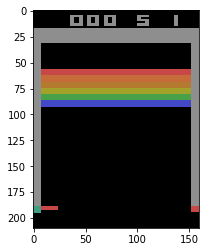

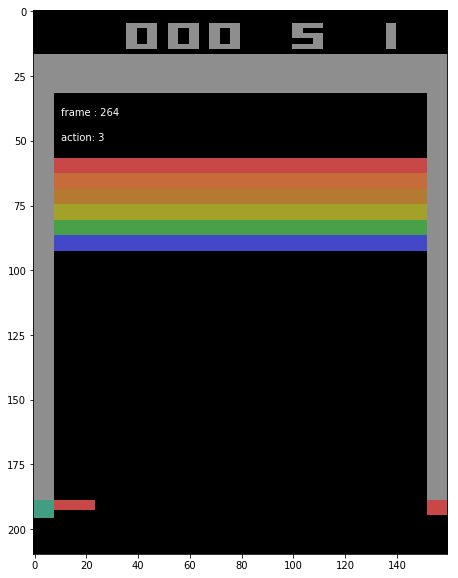

In [9]:
callbacks = []
callbacks = [Visualizer()]

test_hist = dqn.test(env, nb_episodes=1, action_repetition=4,
                     callbacks=callbacks, visualize=False)

# Results

After we have trained everything, we can look at the training history. We then plot the `episode_reward` to see how well it performed over each episode.

<IPython.core.display.Javascript object>


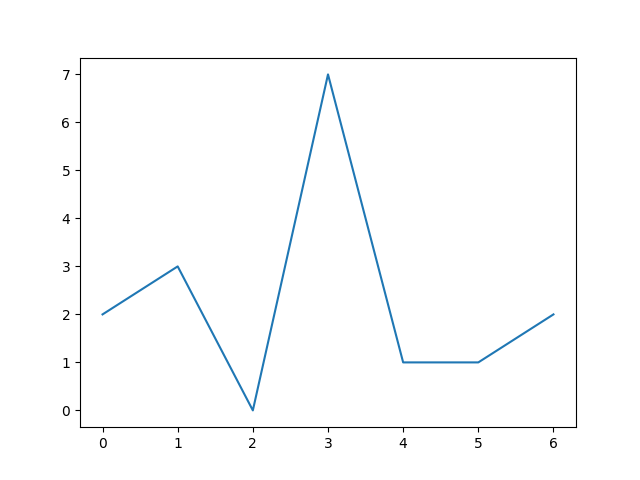

In [22]:
results = pd.read_pickle("sessions/" + train_name +"/hist.pickle")
plt.plot(results['episode_reward'])